In [2]:
from astropy.io import fits
from scipy import signal
from matplotlib import pyplot as plt
import numpy as np
import os
from importlib import reload
import pandas as pd

# package imports
import sparkles.spark as spkl
import sparkles.file_reader as fr
import sparkles.log_readers as lr

import sim.err_budget as eb

## Demo selfRM method plots

This works of the compiled telem created in the OG_vs_telem.ipynb file

In [4]:
RM_dir = '/home/eden/data/2023A/selfRMs/'
selfRM_telem = pd.read_csv('/home/eden/code/sparkles/telem/OG_with_telem.csv')
selfRM_telem.sort_values(by=['name'], inplace=True)

### Demo  SelfRM to OG

In [11]:
# want to make a 3 axis graph that displays 
df_display = selfRM_telem.loc[selfRM_telem['n_modes'] == 411]
selfRM_telem.sort_values(by=['dimm_fwhm'], inplace=True)
# example selfMR pair
sky_sRMs = df_display.selfRM_SKY.unique()
lab_sRM = 'selfRM_20230311_12_LAB_spark_1800_020amps_20seps.fits'

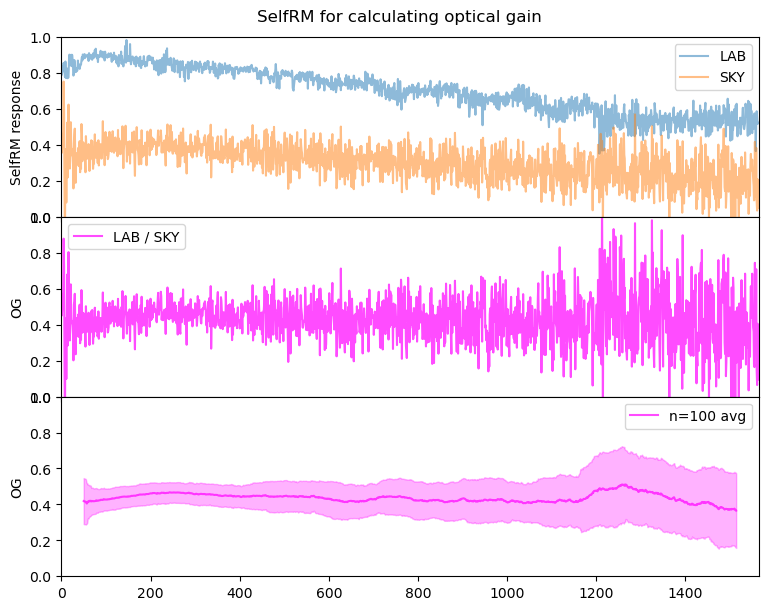

In [29]:
# PLOT: selfRM demonstration
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 7), facecolor='white', sharex=True)
plt.suptitle(f"SelfRM for calculating optical gain", y=0.92 )
fig.subplots_adjust(hspace=0)
colors = plt.cm.plasma(np.linspace(0.3,.7,4))

# Data I am planning on using
lab_data = np.diag(fits.open(RM_dir + 'LAB/' + lab_sRM)[0].data[5])
sky_data_x  = np.diag(fits.open(RM_dir + 'SKY/' + sky_sRMs[0])[0].data[5])
og_ex = sky_data_x / lab_data

data_avg, data_s = spkl.return_rolling(og_ex, n=100)
X = np.arange(data_avg.shape[0])
X_shift = np.arange(50, data_avg.shape[0] + 50)

# ROW 1: raw selfRM and optical gain 
axs[0].plot(lab_data, label = 'LAB', alpha=0.5)
axs[0].plot(sky_data_x, label = 'SKY', alpha=0.5)
axs[0].legend()
axs[0].set_ylabel('SelfRM response')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1565)

# ROW 2: divide for optical gain
axs[1].plot(og_ex, color = 'magenta', alpha=0.7, label='LAB / SKY')
axs[1].set_ylabel('OG')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1565)
axs[1].legend()

#ROW 3: smoth to show general shape
axs[2].fill_between(X_shift, data_avg - data_s, data_avg + data_s, alpha = 0.3, color='magenta')
axs[2].plot(X_shift, data_avg, color='magenta', alpha=0.7, label='n=100 avg')
axs[2].set_ylabel('OG')
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1565)
axs[2].legend()

plt.savefig('../plots/selfRM_raw_to_OG.png',dpi=300)

### Example OG over seeing

In [18]:
# what seeing values do we have?
sky_DIMMS = df_display['dimm_mod'].unique()
print(sky_DIMMS)

[0.83781943 1.03598323 1.27845706 1.467328   1.66906289]


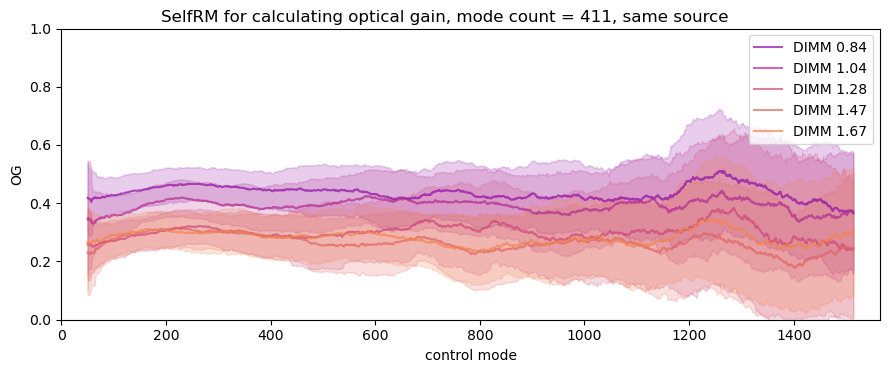

In [24]:
# PLOT: OG across multiple selfRM files
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), facecolor='white', sharex=True)
plt.suptitle(f"SelfRM for calculating optical gain, mode count = 411, same source", y=0.92 )
fig.subplots_adjust(hspace=0)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(sky_sRMs)))

#only need to pull lab data once
lab_data = np.diag(fits.open(RM_dir + 'LAB/' + lab_sRM)[0].data[5])

# go through all selfRMs and check
for i, s in enumerate(sky_sRMs):
    #calc OG for this file
    sky_data_x  = np.diag(fits.open(RM_dir + 'SKY/' + sky_sRMs[i])[0].data[5])
    og_ex = sky_data_x / lab_data

    data_avg, data_s = spkl.return_rolling(og_ex, n=100)
    X_shift = np.arange(50, data_avg.shape[0] + 50)

    axs.fill_between(X_shift, data_avg - data_s, data_avg + data_s, alpha = 0.2, color=colors[i])
    axs.plot(X_shift, data_avg, alpha=0.7, label=f'DIMM {np.round(sky_DIMMS[i], 2)}', color=colors[i])

axs.set_ylabel('OG')
axs.set_xlabel('control mode')
axs.set_ylim(0,1)
axs.set_xlim(0,1565)
axs.legend()
plt.tight_layout()
plt.savefig('../plots/selfRM_modes_DIMM_vary.png',dpi=300)


## hmm what is this noise

In [82]:
RM_dir = '/home/eden/data/selfRMs_all/'
selfRM_compare2 = pd.read_csv('/home/eden/code/sparkles/telem/csv/selfRM_mags_comp_clean.csv')

In [83]:
# create a basic OG table
# for each row, calc optical gain
import matplotlib.pylab as pl

OGains = []
OGains_mean = []
OGains_std = []
OGains_series = []

for idx, row in selfRM_compare2.iterrows():
    # pull the fits files from the right place
    if(row['type'] == 'SKY'):
        data_sky = fits.open(RM_dir + 'SKY/' + row['selfRM'])[0].data
        data_lab = fits.open(RM_dir +'LAB/' + row['l_selfRM'])[0].data
        diag_sky = np.diag(data_sky[5])
        diag_lab = np.diag(data_lab[5])
        OG_series = diag_sky/diag_lab
        OG = np.median(OG_series)
        OG_m = np.mean(OG_series)
        OG_std = np.std(OG_series)
        OGains.append(OG)
        OGains_mean.append(OG_m)
        OGains_std.append(OG_std)
        OGains_series.append(OG_series)

In [84]:
OGains_series = np.array(OGains_series)
mean_normal = np.array([OGains_series[i] / OGains_mean[i] for i in range(len(OGains))])

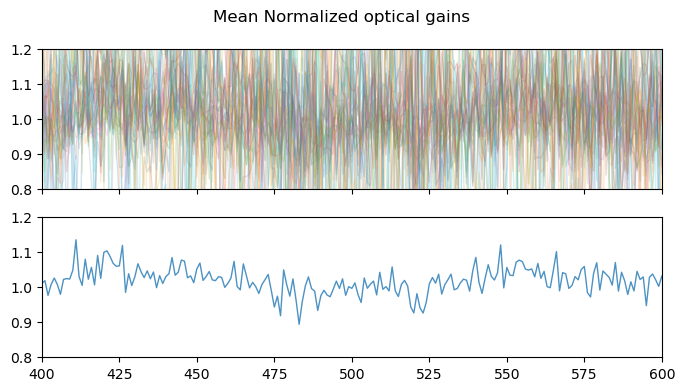

In [88]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,4), facecolor='white', sharex=True)

for i in range(len(OGains)):
    axs[0].plot(mean_normal[i], alpha = 0.2, lw=1,)
axs[0].set_ylim(0.8,1.2)

axs[1].plot(np.median(mean_normal, axis=0), lw=1, alpha=0.8, label='median')

plt.ylim(0.8,1.2)
plt.xlim(400, 600)
plt.suptitle('Mean Normalized optical gains')
plt.show()

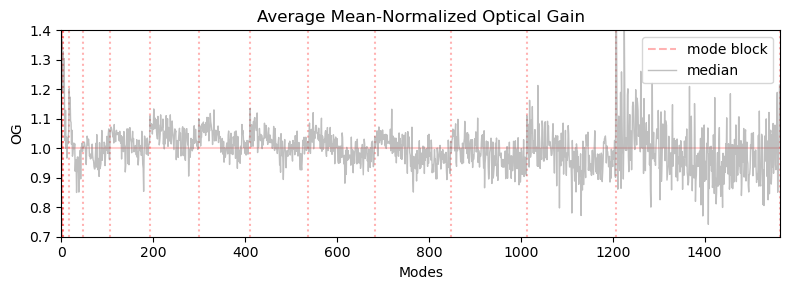

In [17]:
# the average selfRM
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,3), facecolor='white', sharex=True)

for mc in mode_cumulative:
    if mc==1:
        plt.axvline(mc+0.5, color='red', alpha=0.3,label='mode block', ls='dashed')
    else:
        plt.axvline(mc+0.5, color='red', alpha=0.3, ls='dotted')

plt.axhline(1, color='red', alpha=0.2)

#plt.plot(np.mean(mean_normal, axis=0), lw=1, alpha=0.5, label='mean')
plt.plot(np.median(mean_normal, axis=0), lw=1, alpha=0.5, label='median', color='gray')

plt.xlabel('Modes')
plt.ylabel('OG')

plt.xlim(0,mode_cumulative[-1])
plt.ylim(0.7, 1.4)

plt.legend()
plt.title('Average Mean-Normalized Optical Gain')
plt.tight_layout()
plt.savefig('../plots/selfRM_OG_modes_mean_norm.png',dpi=300)

In [72]:
mode_cumulative

array([   1,    2,    3,   17,   46,  106,  193,  298,  411,  536,  681,
        847, 1013, 1207, 1564])

Text(0.5, 1.0, 'Average Mean Normalized Optical Gain')

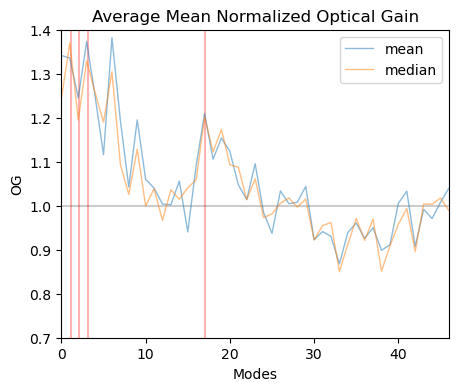

In [18]:
# the average selfRM
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), facecolor='white', sharex=True)

for mc in mode_cumulative:
    plt.axvline(mc+0.1, color='red', alpha=0.3)

plt.axhline(1, color='black', alpha=0.2)

plt.plot(np.mean(mean_normal, axis=0), lw=1, alpha=0.5, label='mean')
plt.plot(np.median(mean_normal, axis=0), lw=1, alpha=0.5, label='median')

plt.xlabel('Modes')
plt.ylabel('OG')

plt.ylim(0.7, 1.4)
plt.xlim(0,mode_cumulative[4])

plt.legend()
plt.title('Average Mean Normalized Optical Gain')

## Testing bootstrap

In [19]:
test_OG_series = OGains_series[0]

In [60]:
n = test_OG_series.shape[0]
m = 10000
samples = np.random.choice(test_OG_series, size=(n,m))

In [61]:
import scipy as sp
print("       STD:", np.std(test_OG_series))
print("       SEM:", sp.stats.sem(test_OG_series))
print(' Bootstrap:', np.std(np.mean(samples, axis=0)))

       STD: 0.14568281
       SEM: 0.0036849264619857078
 Bootstrap: 0.0036851976


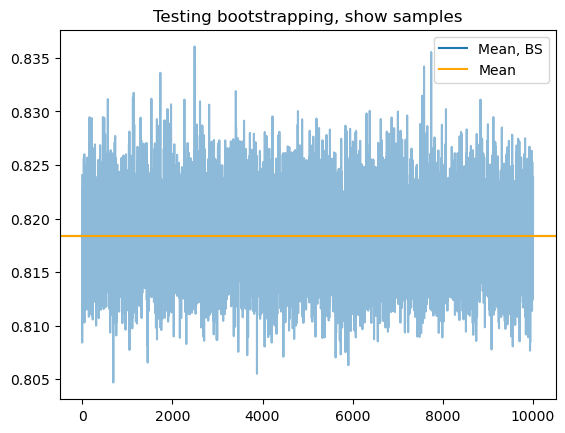

In [37]:
plt.plot(np.mean(samples, axis=0), alpha=0.5)
plt.axhline(np.mean(samples), label='Mean, BS')
plt.axhline(np.mean(test_OG_series), color='orange',label='Mean')
plt.title('Testing bootstrapping, show samples')
plt.legend()

In [74]:
X = np.arange(test_OG_series.shape[0])
mean = np.mean(test_OG_series)
err = np.std(np.mean(samples, axis=0))

(0.0, 1564.0)

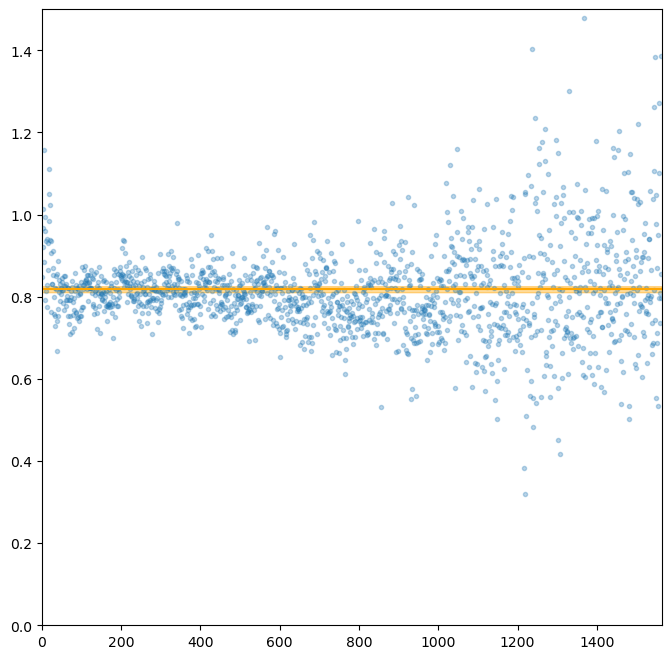

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8), facecolor='white', sharex=True)
plt.plot(test_OG_series, alpha=0.3, ls='None', marker='.')
plt.axhline(mean, color='orange',label='Mean')
plt.fill_between(np.arange(test_OG_series.shape[0]), mean - 2*err, mean + 2*err, alpha = 0.4, color='orange')
plt.ylim(0,1.5)
plt.xlim(0, 1564)

# SelfRMs vs. Seeing vs. Modes

In this notebooks I will attempt to get modal information about the different observations. 

Things to think about: 
- mapping from gain array to the modes found
- making sure each selfRM has its 

UPDATE => comparisons now done in DuckDB

This section is for transfering a file list to a csv with sparkle params for files. More intensive csv merging should be done in duck for faster re-doing

In [2]:
reload(fr)

<module 'sparkles.file_reader' from '/home/eden/code/sparkles/sparkles/file_reader.py'>

## part 0. Making selfRM table

In [2]:
log_dir_23A = "/home/eden/data/2023A/log/"
f_spark_telem = log_dir_23A + 'spkl_teldump_23A_clean.csv'
df_spkl_telem = pd.read_csv(f_spark_telem)

In [3]:
df_spkl_telem

,UT,MOD,TRIG,HZ,SEPS,ANGS,AMPS
0,2022-12-02T18:38:05,False,False,NaN,NaN,NaN,NaN
1,2022-12-02T18:38:15,False,False,NaN,NaN,NaN,NaN
2,2022-12-02T18:38:25,False,False,NaN,NaN,NaN,NaN
3,2022-12-02T18:38:35,False,False,NaN,NaN,NaN,NaN
4,2022-12-02T19:24:00,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
270395,2023-03-17T10:44:02,False,False,NaN,NaN,NaN,NaN
270396,2023-03-17T10:44:12,False,False,NaN,NaN,NaN,NaN
270397,2023-03-17T10:44:22,False,False,NaN,NaN,NaN,NaN
270398,2023-03-17T10:44:32,False,False,NaN,NaN,NaN,NaN


In [13]:
RM_dir23A_lab = "/home/eden/data/selfRMs_all/LAB/"
RM_dir23A_sky = "/home/eden/data/selfRMs_all/SKY/"
RM_dir23A_tst = "/home/eden/data/selfRMs_all/TST/"
selfRM_lab_list = os.listdir(RM_dir23A_lab)
selfRM_sky_list = os.listdir(RM_dir23A_sky)
selfRM_tst_list = os.listdir(RM_dir23A_tst)

In [9]:
selfRM_lab_list

['selfRM_20230307_08_lab_sparkles_sep20_amp002.fits',
 'selfRM_20230311_12_LAB_loopOff_1800_20stlng.fits',
 'selfRM_20230311_12_LAB_noSpark_0600_fullgains.fits',
 'selfRM_20230311_12_LAB_noSpark_0900_fullgains.fits',
 'selfRM_20230311_12_LAB_noSpark_1200_fullgains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_000gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_020gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_040gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_060gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_20stlng.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_fullgains.fits',
 'selfRM_20230311_12_LAB_spark_0600_010amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0600_020amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0600_050amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0900_010amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0900_020amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0900_050amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_1200_010amps_20seps.fits'

In [14]:
selfRM_param_list = []
for tmp in selfRM_sky_list:
    tmp_path = RM_dir23A_sky + tmp
    param_tmp = [tmp, "SKY"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, f_spark_telem))
    selfRM_param_list.append(param_tmp)
for tmp in selfRM_lab_list:
    tmp_path = RM_dir23A_lab + tmp
    param_tmp = [tmp, "LAB"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, f_spark_telem))
    selfRM_param_list.append(param_tmp)
for tmp in selfRM_tst_list:
    tmp_path = RM_dir23A_tst + tmp
    param_tmp = [tmp, "TST"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, f_spark_telem))
    selfRM_param_list.append(param_tmp)

2023-03-05T05:24:10
2023-03-05T05:18:53
2023-03-07T03:53:53
2023-03-08T02:17:29
2023-03-10T07:51:12
2023-03-10T10:02:12
2023-03-10T22:49:41
2023-03-11T03:32:47
2023-03-11T03:35:49
2023-03-11T03:29:49
2023-03-12T03:01:06
2023-03-13T04:15:30
2023-03-13T02:20:10
2023-03-13T02:25:21
2023-03-13T10:20:47
2023-03-14T05:51:29
2023-03-16T00:57:06
2023-03-16T02:50:26
2023-03-16T03:08:40
2023-03-16T10:24:33
2023-03-16T07:02:31
2023-03-17T03:53:33
2023-03-17T04:14:23
2023-03-17T04:28:52
2023-03-17T04:34:56
2023-03-17T04:42:36
2023-03-17T04:50:10
2023-03-17T04:59:39
2023-03-17T07:23:42
2023-03-17T03:09:30
2023-03-17T03:09:30
2023-03-17T09:57:39
2022-12-11T02:21:27
2022-12-12T01:48:57
2022-12-11T02:24:20
2022-12-13T03:32:15
2023-03-08T00:06:36
2023-03-11T23:28:09
2023-03-11T22:00:40
2023-03-11T22:38:40
2023-03-11T21:27:24
2023-03-11T20:44:06
2023-03-11T20:32:40
2023-03-11T22:20:58
2023-03-11T22:10:35
2023-03-11T21:53:36
2023-03-11T22:54:43
2023-03-11T22:46:49
2023-03-11T22:34:34
2023-03-11T21:40:51


In [15]:
sRM_columns = ['selfRM', 'type', 'UT', 'MOD', 'TRIG', 'HZ', 'SEPS','ANGS','AMPS']
df_selfRM_spark = pd.DataFrame(selfRM_param_list, columns = sRM_columns)

In [16]:
df_selfRM_spark.to_csv('/srv/nas/users/eden/selfRM_telem_22B_23A_more.csv')